In [1]:
#import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
import nltk

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay


#disable warning messages inside the notebook
pd.options.mode.chained_assignment = None

## I. Data Import

In [2]:
#load Kaggle dataset
df = pd.read_csv('fake-news/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


## II. Data Exploration

In [3]:
#display general info to the imported data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [4]:
#briefly check on the label distribution
df_reliable = df.loc[df['label'] == 0]
df_unreliable = df.loc[df['label'] == 1]

total = len(df_reliable) + len(df_unreliable)

print('Control: sum: {} , reliable: {}, unreliable: {}'.format(total, len(df_reliable), len(df_unreliable)))
print('Ratio reliable/unreliable messages: {}:{}'. \
          format(round(len(df_reliable) / total, 2), round(len(df_unreliable) / total, 2)))

Control: sum: 20800 , reliable: 10387, unreliable: 10413
Ratio reliable/unreliable messages: 0.5:0.5


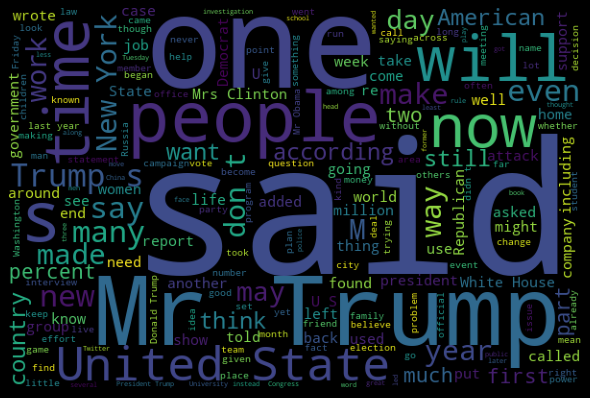

In [5]:
#create a wordcloud for the label reliable
reliable_wordcloud = WordCloud(width=600, height=400).generate(' '.join(df_reliable['text']))
plt.figure( figsize=(8,6), facecolor='k')
plt.imshow(reliable_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

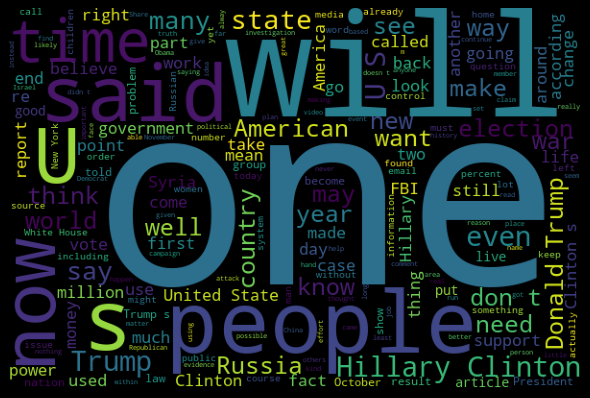

In [6]:
#create a wordcloud for the label unreliable
unreliable_wordcloud = WordCloud(width=600, height=400).generate(' '.join(str(item) for item in df_unreliable['text']))
plt.figure( figsize=(8,6), facecolor='k')
plt.imshow(unreliable_wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

In [7]:
#anlaysis of the text length for text labeled as reliable
df_reliable['text_length'] = df['text'].str.len()
df_reliable.head()

,id,title,author,text,label,text_length
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160.0
5,5,Jackie Mason: Hollywood Would Love Trump if He...,Daniel Nussbaum,"In these trying times, Jackie Mason is the Voi...",0,1192.0
7,7,Benoît Hamon Wins French Socialist Party’s Pre...,Alissa J. Rubin,"PARIS — France chose an idealistic, traditi...",0,4923.0
8,8,Excerpts From a Draft Script for Donald Trump’...,NaN,Donald J. Trump is scheduled to make a highly ...,0,8177.0
9,9,"A Back-Channel Plan for Ukraine and Russia, Co...",Megan Twohey and Scott Shane,A week before Michael T. Flynn resigned as nat...,0,10261.0


In [8]:
df_reliable['text_length'].describe()

count    10387.000000
mean      5214.130452
std       4313.791236
min          3.000000
25%       2397.000000
50%       4591.000000
75%       7015.000000
max      85948.000000
Name: text_length, dtype: float64

In [9]:
df_reliable['text_length'].sort_values()

7141         3.0
18567       13.0
13068      113.0
13568      134.0
7047       140.0
          ...   
2736     55746.0
10460    57846.0
11628    63384.0
10204    75897.0
13745    85948.0
Name: text_length, Length: 10387, dtype: float64

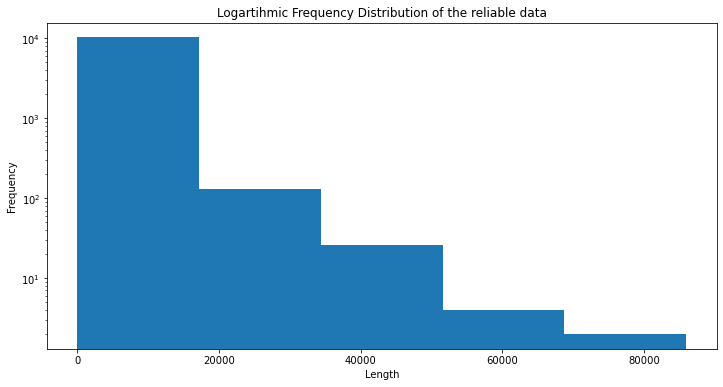

In [58]:
#plot a histogram of the text length distribution for reliable text
plt.figure(figsize=(12,6))
df_reliable['text_length'].plot(bins=5, kind='hist')  
plt.title("Logartihmic Frequency Distribution of the reliable data")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.yscale("log")

In [11]:
#anlaysis of the text length for text labeled as unreliable
df_unreliable['text_length'] = df['text'].str.len()
df_unreliable.head()

,id,title,author,text,label,text_length
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930.0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692.0
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237.0
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938.0
6,6,Life: Life Of Luxury: Elton John’s 6 Favorite ...,NaN,Ever wonder how Britain’s most iconic pop pian...,1,2729.0


In [12]:
df_unreliable['text_length'].describe()

count     10374.000000
mean       3890.471467
std        5759.522906
min           1.000000
25%        1056.250000
50%        2362.000000
75%        4811.500000
max      142961.000000
Name: text_length, dtype: float64

In [13]:
df_unreliable['text_length'].sort_values()

4398     1.0
18998    1.0
10465    1.0
17794    1.0
12374    1.0
        ... 
18479    NaN
18757    NaN
19157    NaN
19227    NaN
19388    NaN
Name: text_length, Length: 10413, dtype: float64

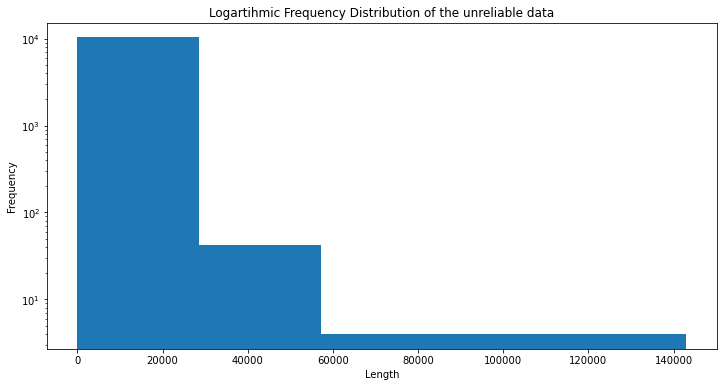

In [59]:
#plot a histogram of the text length distribution for unreliable text
plt.figure(figsize=(12,6))
df_unreliable['text_length'].plot(bins=5, kind='hist')  
plt.title("Logartihmic Frequency Distribution of the unreliable data")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.yscale("log")

## III. Data Pre-Processing

In [15]:
#remove records which include np.nan in the text column
check_nan = df['text'].isnull().sum()
print(check_nan)

df_cleaned = df[df['text'].notnull()]
df_cleaned.info()

39
<class 'pandas.core.frame.DataFrame'>
Int64Index: 20761 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20761 non-null  int64 
 1   title   20203 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20761 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 973.2+ KB


In [16]:
#I will set the cut off for the maximum text length to 60.000 characters
#and remove the outliers from the original dataset
df_cleaned['text_length'] = df_cleaned['text'].str.len()
df_cleaned = df_cleaned[df_cleaned['text_length'] < 60000]
df_cleaned.describe()

,id,label,text_length
count,20746.000000,20746.000000,20746.000000
mean,10401.797359,0.499470,4488.466259
std,6005.259635,0.500012,4495.943485
min,0.000000,0.000000,1.000000
25%,5201.250000,0.000000,1627.250000
50%,10402.500000,0.000000,3356.000000
75%,15604.750000,1.000000,6263.750000
max,20799.000000,1.000000,57846.000000


In [17]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20746 entries, 0 to 20799
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           20746 non-null  int64 
 1   title        20188 non-null  object
 2   author       18829 non-null  object
 3   text         20746 non-null  object
 4   label        20746 non-null  int64 
 5   text_length  20746 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 1.1+ MB


That action removed 15 records in total.

In [18]:
#printing the punctuation values which I am going to remove from the corpus
punc = string.punctuation 
print('Characters to be removed off the dataset: {}'.format(punc)) 

Characters to be removed off the dataset: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [19]:
%%time

#remove punctuations and lower all characters
def remove_punctuation_lower(s): 
    """ Helper function to remove punctuation from a string s
        and to lower the characters: any string """ 
    
    try: 
        nopunc = ''.join(char for char in s if char not in string.punctuation)
        nopunc = nopunc.lower()
    except e: 
        print(e)
    
    return nopunc

#apply remove_punctuation_lower() to the dataframe
df_cleaned['text_nopunc'] = df_cleaned['text'].apply(remove_punctuation_lower)
df_cleaned.head()

CPU times: user 8.55 s, sys: 139 ms, total: 8.69 s
Wall time: 8.74 s


,id,title,author,text,label,text_length,text_nopunc
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,house dem aide we didn’t even see comey’s lett...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,ever get the feeling your life circles the rou...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,why the truth might get you fired october 29 2...
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,videos 15 civilians killed in single us airstr...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,print \nan iranian woman has been sentenced to...


In [20]:
%%time

#remove stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def remove_stopwords(s): 
    """ Helper function to remove stopwords from a string s: any string """ 
    
    try: 
        tokens = word_tokenize(s)
        #no_stopwords = [word for word in tokens if not word in stopwords.words('english')]
        #no_stopwords = " ".join(no_stopwords)
        no_stopwords = ' '.join(word for word in tokens if word not in stop_words)
    except e:
        print(e)
    
    return no_stopwords

#apply remove_stopwords() to the dataframe
df_cleaned['text_no_stopwords'] = df_cleaned['text_nopunc'].apply(remove_stopwords)
df_cleaned['text_no_stopwords_length'] = df_cleaned['text_no_stopwords'].str.len()
df_cleaned.describe()

[nltk_data] Downloading package stopwords to /Users/pika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


CPU times: user 34 s, sys: 201 ms, total: 34.2 s
Wall time: 34.5 s


,id,label,text_length,text_no_stopwords_length
count,20746.000000,20746.000000,20746.000000,20746.000000
mean,10401.797359,0.499470,4488.466259,3153.300540
std,6005.259635,0.500012,4495.943485,3116.689927
min,0.000000,0.000000,1.000000,0.000000
25%,5201.250000,0.000000,1627.250000,1160.000000
50%,10402.500000,0.000000,3356.000000,2387.000000
75%,15604.750000,1.000000,6263.750000,4372.000000
max,20799.000000,1.000000,57846.000000,39895.000000


In [21]:
%%time

#lemmatization
nltk.download('wordnet')
nltk.download('omw-1.4')

def lemmatization(s):
    """ Helper function to convert words into their dictionary form from a string s: any string """ 
    
    wnl = WordNetLemmatizer()
    
    try:
        tokens = word_tokenize(s)
        lemmas = ' '.join([wnl.lemmatize(word) for word in tokens])
    except e:
        print(e)                  
                       
    return lemmas

#apply lemmatization() to the dataframe
df_cleaned['text_lemmas'] = df_cleaned['text_no_stopwords'].apply(lemmatization)

[nltk_data] Downloading package wordnet to /Users/pika/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/pika/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


CPU times: user 53.2 s, sys: 292 ms, total: 53.5 s
Wall time: 53.8 s


In [22]:
#quick check on how many words and punctuations have been removed
df_cleaned['count_before'] = df_cleaned['text_nopunc'].apply(lambda x: len(str(x).split()))
df_cleaned['count_after'] = df_cleaned['text_lemmas'].apply(lambda x: len(str(x).split()))
df_cleaned.head()

,id,title,author,text,label,text_length,text_nopunc,text_no_stopwords,text_no_stopwords_length,text_lemmas,count_before,count_after
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,4930,house dem aide we didn’t even see comey’s lett...,house dem aide ’ even see comey ’ letter jason...,3338,house dem aide ’ even see comey ’ letter jason...,816,464
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,4160,ever get the feeling your life circles the rou...,ever get feeling life circles roundabout rathe...,2857,ever get feeling life circle roundabout rather...,710,422
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,7692,why the truth might get you fired october 29 2...,truth might get fired october 29 2016 tension ...,5328,truth might get fired october 29 2016 tension ...,1263,736
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,3237,videos 15 civilians killed in single us airstr...,videos 15 civilians killed single us airstrike...,2268,video 15 civilian killed single u airstrike id...,557,325
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,938,print \nan iranian woman has been sentenced to...,print iranian woman sentenced six years prison...,688,print iranian woman sentenced six year prison ...,153,98


In [23]:
print('Word count before: {}, after: {}, diff: {} or {:.0f}%'.format( \
                                                    df_cleaned['count_before'].sum(), df_cleaned['count_after'].sum(), \
                                                    df_cleaned['count_after'].sum() - df_cleaned['count_before'].sum(), \
                                                    (df_cleaned['count_after'].sum()/df_cleaned['count_before'].sum()-1)*100))

Word count before: 15496880, after: 9429042, diff: -6067838 or -39%


## IV. Vectorization

In [24]:
%%time

#transform the list of tokens into a vector
vectorizer = CountVectorizer()
v_fit = vectorizer.fit(df_cleaned['text_lemmas'])
v_transform = vectorizer.transform(df_cleaned['text_lemmas'])

print("Total number of words : ",len(vectorizer.vocabulary_))
print('Vector shape after transformation: {}'.format(v_transform.shape))

Total number of words :  187630
Vector shape after transformation: (20746, 187630)
CPU times: user 10.6 s, sys: 203 ms, total: 10.8 s
Wall time: 10.8 s


## V. Modelling with TF-IDF

In [25]:
#calculate the TF-IDF
tfidf_transformer = TfidfTransformer().fit(v_transform)
text_tfidf = tfidf_transformer.transform(v_transform)

In [26]:
#split the corpus into a train and test set with a ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(text_tfidf, df_cleaned['label'], test_size=0.2, random_state=42)

print("train dataset features size : ",X_train.shape)
print("train dataset label size", y_train.shape)
print("--"*10)
print("test dataset features size", X_test.shape)
print("test dataset lable size", y_test.shape)

train dataset features size :  (16596, 187630)
train dataset label size (16596,)
--------------------
test dataset features size (4150, 187630)
test dataset lable size (4150,)


In [27]:
%%time

#train the model on the training data with Naive Bayes
naive_bayes_classifier = MultinomialNB().fit(X_train, y_train)

#predict labels using the test data
y_pred = naive_bayes_classifier.predict(X_test)

CPU times: user 67.1 ms, sys: 9.78 ms, total: 76.9 ms
Wall time: 74.3 ms


## Evaluation

In [28]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.99      0.86      2099
           1       0.99      0.69      0.81      2051

    accuracy                           0.84      4150
   macro avg       0.88      0.84      0.84      4150
weighted avg       0.88      0.84      0.84      4150



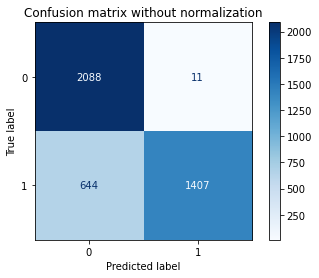

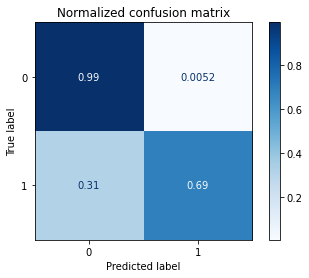

In [29]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        naive_bayes_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## Repetition of TF-IDF Modelling & Evaluation with different ML algorithms

In [30]:
%%time

#train the model on the training data with Support Vector Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier = svm_classifier.fit(X_train, y_train)

#predict labels using the test data
y_pred = svm_classifier.predict(X_test)

CPU times: user 4min 22s, sys: 1.06 s, total: 4min 23s
Wall time: 4min 24s


In [31]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2099
           1       0.95      0.96      0.96      2051

    accuracy                           0.96      4150
   macro avg       0.96      0.96      0.96      4150
weighted avg       0.96      0.96      0.96      4150



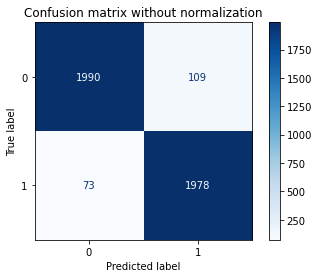

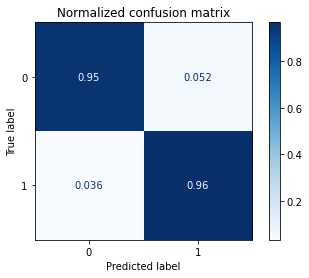

In [32]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

In [33]:
%%time

#train the model on the training data with Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)  

#predict labels using the test data
y_pred = dt_classifier.predict(X_test)

CPU times: user 23.1 s, sys: 57.7 ms, total: 23.2 s
Wall time: 23.2 s


In [34]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      2099
           1       0.87      0.90      0.89      2051

    accuracy                           0.89      4150
   macro avg       0.89      0.89      0.89      4150
weighted avg       0.89      0.89      0.89      4150



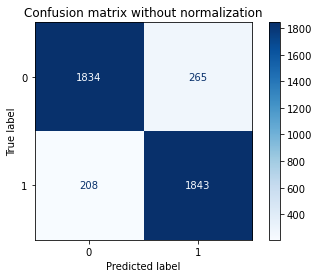

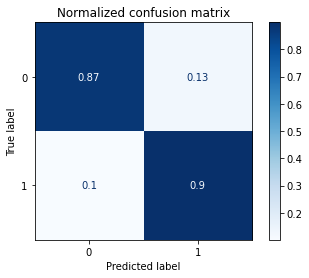

In [35]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dt_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## VII. Modelling with TF

In [36]:
#split the corpus into a train and test set with a ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(v_transform, df_cleaned['label'], test_size=0.2, random_state=42)

print("train dataset features size : ",X_train.shape)
print("train dataset label size", y_train.shape)
print("--"*10)
print("test dataset features size", X_test.shape)
print("test dataset lable size", y_test.shape)

train dataset features size :  (16596, 187630)
train dataset label size (16596,)
--------------------
test dataset features size (4150, 187630)
test dataset lable size (4150,)


In [37]:
%%time

#train the model on the training data with Naive Bayes
naive_bayes_classifier = MultinomialNB().fit(X_train, y_train)

#predict labels using the test data
y_pred = naive_bayes_classifier.predict(X_test)

CPU times: user 59.9 ms, sys: 7.18 ms, total: 67 ms
Wall time: 66 ms


In [38]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.97      0.91      2099
           1       0.96      0.84      0.90      2051

    accuracy                           0.91      4150
   macro avg       0.91      0.91      0.91      4150
weighted avg       0.91      0.91      0.91      4150



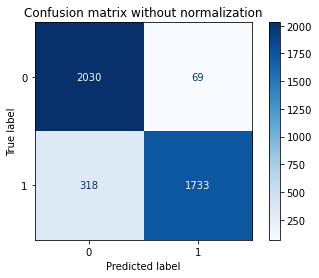

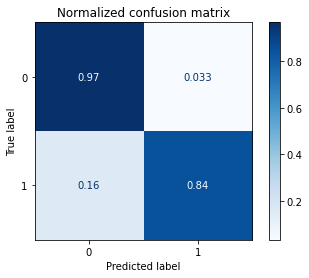

In [39]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        naive_bayes_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## Repetition of TF Modelling & Evaluation with different ML algorithms

In [40]:
%%time

#train the model on the training data with Support Vector Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier = svm_classifier.fit(X_train, y_train)

#predict labels using the test data
y_pred = svm_classifier.predict(X_test)

CPU times: user 1min 30s, sys: 272 ms, total: 1min 30s
Wall time: 1min 31s


In [41]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2099
           1       0.93      0.94      0.94      2051

    accuracy                           0.94      4150
   macro avg       0.94      0.94      0.94      4150
weighted avg       0.94      0.94      0.94      4150



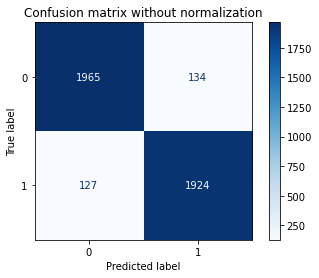

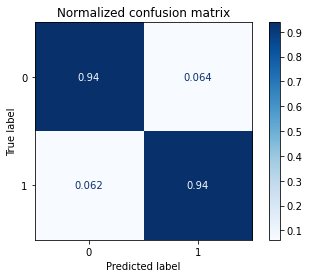

In [42]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

In [43]:
%%time

#train the model on the training data with Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)  

#predict labels using the test data
y_pred = dt_classifier.predict(X_test)

CPU times: user 18.5 s, sys: 38.1 ms, total: 18.5 s
Wall time: 18.5 s


In [44]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.90      2099
           1       0.89      0.90      0.90      2051

    accuracy                           0.90      4150
   macro avg       0.90      0.90      0.90      4150
weighted avg       0.90      0.90      0.90      4150



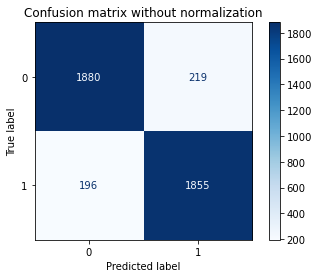

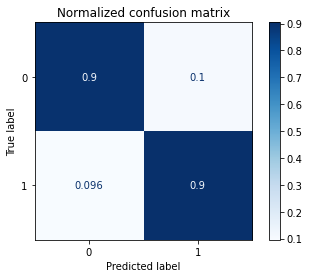

In [45]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dt_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## VIII. Bigram Vectorization

In [46]:
%%time

#transform the list of tokens into a vector
vectorizer = CountVectorizer(ngram_range=(2,2))
v_fit = vectorizer.fit(df_cleaned['text_lemmas'])
v_transform = vectorizer.transform(df_cleaned['text_lemmas'])

print("Total number of words : ",len(vectorizer.vocabulary_))
print('Vector shape after transformation: {}'.format(v_transform.shape))

Total number of words :  4215660
Vector shape after transformation: (20746, 4215660)
CPU times: user 36.6 s, sys: 471 ms, total: 37.1 s
Wall time: 37.1 s


## IX. Modelling with Bigram

In [47]:
#split the corpus into a train and test set with a ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(v_transform, df_cleaned['label'], test_size=0.2, random_state=42)

print("train dataset features size : ",X_train.shape)
print("train dataset label size", y_train.shape)
print("--"*10)
print("test dataset features size", X_test.shape)
print("test dataset lable size", y_test.shape)

train dataset features size :  (16596, 4215660)
train dataset label size (16596,)
--------------------
test dataset features size (4150, 4215660)
test dataset lable size (4150,)


In [48]:
%%time

#train the model on the training data with Naive Bayes
naive_bayes_classifier = MultinomialNB().fit(X_train, y_train)

#predict labels using the test data
y_pred = naive_bayes_classifier.predict(X_test)

CPU times: user 350 ms, sys: 87.9 ms, total: 438 ms
Wall time: 437 ms


In [49]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      2099
           1       0.97      0.91      0.94      2051

    accuracy                           0.94      4150
   macro avg       0.94      0.94      0.94      4150
weighted avg       0.94      0.94      0.94      4150



## Evaluation

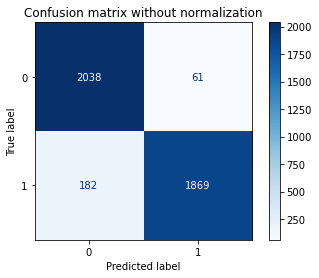

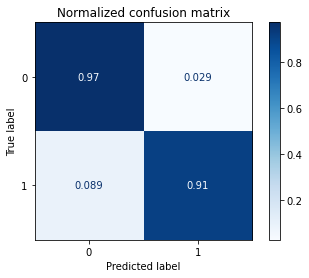

In [50]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        naive_bayes_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

## Repetition of Bigram Modelling & Evaluation with different ML algorithms

In [51]:
%%time

#train the model on the training data with Support Vector Classifier
svm_classifier = SVC(kernel='linear')
svm_classifier = svm_classifier.fit(X_train, y_train)

#predict labels using the test data
y_pred = svm_classifier.predict(X_test)

CPU times: user 16min 3s, sys: 1.44 s, total: 16min 5s
Wall time: 16min 5s


In [52]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.87      0.90      2099
           1       0.87      0.95      0.91      2051

    accuracy                           0.91      4150
   macro avg       0.91      0.91      0.91      4150
weighted avg       0.91      0.91      0.91      4150



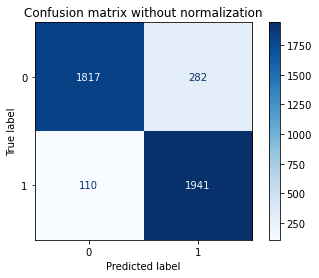

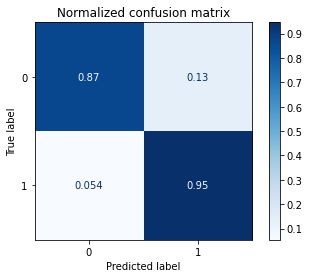

In [53]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        svm_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)

In [54]:
%%time

#train the model on the training data with Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train, y_train)  

#predict labels using the test data
y_pred = dt_classifier.predict(X_test)

CPU times: user 6min 6s, sys: 645 ms, total: 6min 7s
Wall time: 6min 7s


In [55]:
#print the evaluation matrix containing the precision, recall and f1-score
print (classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.87      0.87      2099
           1       0.87      0.88      0.87      2051

    accuracy                           0.87      4150
   macro avg       0.87      0.87      0.87      4150
weighted avg       0.87      0.87      0.87      4150



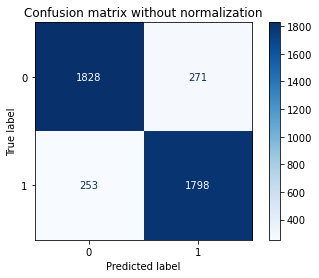

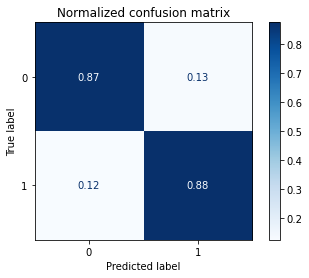

In [56]:
#plot non-normalized confusion matrix
titles_options = [
    ("Confusion matrix without normalization", None),
    ("Normalized confusion matrix", "true"),
]

for title, normalize in titles_options:
    disp = ConfusionMatrixDisplay.from_estimator(
        dt_classifier,
        X_test,
        y_test,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    disp.ax_.set_title(title)